In [1]:
using PyCall, PyPlot, Statistics
using ClimateMARGO
inset_locator = pyimport("mpl_toolkits.axes_grid.inset_locator");
mpl = pyimport("matplotlib");

┌ Info: Precompiling ClimateMARGO [39978bfe-ac6a-4fbe-9981-75100ee30276]
└ @ Base loading.jl:1273


## Make figures from default model configuration for manuscript

#### Approach 1: Cost-benefit analysis

In [2]:
model = ClimateModel();
@time optimize_controls!(model, obj_option = "net_benefit");


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solve_Succeeded
 38.670500 seconds (116.04 M allocations: 6.564 GiB, 5.67% gc time)


In [3]:
stat_dict = Dict("mitigate" => [], "remove" => [], "geoeng" => [], "adapt" => [], "maxTnoG" => [], "maxT" => [], "maxCO2" => [])
ρdict = Dict()
ρs = 0.:0.0025:0.05

for ρ in ρs
    tmp_model = ClimateModel();
    tmp_model.economics.utility_discount_rate = ρ
    @time optimize_controls!(tmp_model, obj_option = "net_benefit");
    ρdict[ρ] = tmp_model
    
    append!(stat_dict["mitigate"], mean(tmp_model.controls.mitigate))
    append!(stat_dict["remove"], mean(tmp_model.controls.remove))
    append!(stat_dict["adapt"], mean(tmp_model.controls.adapt))
    append!(stat_dict["geoeng"], mean(tmp_model.controls.geoeng))
    append!(stat_dict["maxTnoG"], maximum(δT_no_geoeng(tmp_model)))
    append!(stat_dict["maxT"], maximum(δT(tmp_model)))
    append!(stat_dict["maxCO2"], maximum(CO₂(tmp_model)))
end

Solve_Succeeded
  0.079145 seconds (118.29 k allocations: 4.479 MiB)
Solve_Succeeded
  0.076789 seconds (118.43 k allocations: 4.488 MiB)
Solve_Succeeded
  0.078721 seconds (118.28 k allocations: 4.479 MiB)
Solve_Succeeded
  0.074344 seconds (118.43 k allocations: 4.489 MiB)
Solve_Succeeded
  0.074544 seconds (114.34 k allocations: 4.403 MiB)
Solve_Succeeded
  0.080250 seconds (110.54 k allocations: 4.336 MiB)
Solve_Succeeded
  0.064843 seconds (106.45 k allocations: 4.251 MiB)
Solve_Succeeded
  0.067280 seconds (106.60 k allocations: 4.261 MiB)
Solve_Succeeded
  0.093433 seconds (105.10 k allocations: 4.219 MiB, 24.54% gc time)
Solve_Succeeded
  0.067565 seconds (105.25 k allocations: 4.228 MiB)
Solve_Succeeded
  0.063706 seconds (101.16 k allocations: 4.143 MiB)
Solve_Succeeded
  0.061032 seconds (101.31 k allocations: 4.152 MiB)
Solve_Succeeded
  0.059762 seconds (101.16 k allocations: 4.143 MiB)
Solve_Succeeded
  0.062626 seconds (101.31 k allocations: 4.152 MiB)
Solve_Succeeded
  

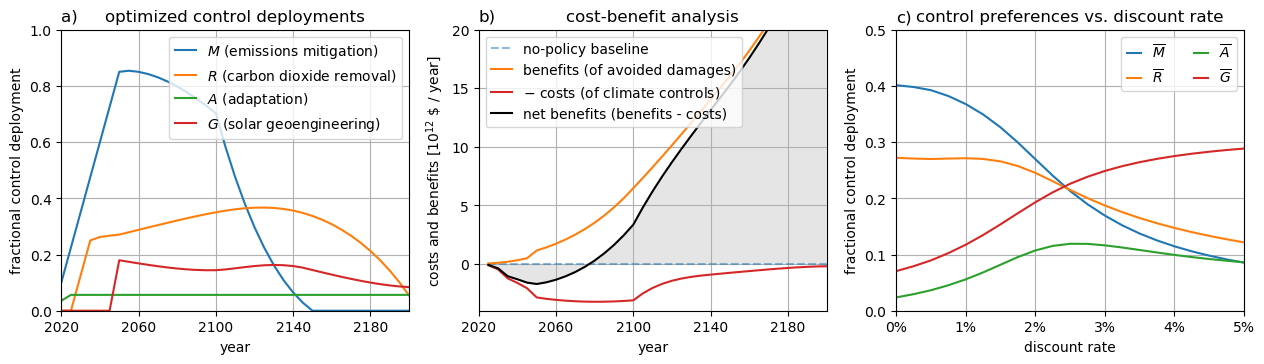

Maximum warming: 1.3471290554400948

In [4]:
fig = figure(figsize=(12.75,3.75))

fig.add_subplot(1,3,1)
plot_controls(model)
legend(handlelength=1.5, loc="upper right")
add_label("a)")
xticks(model.domain[1]:40.:2200.)

ax = fig.add_subplot(1,3,2)
plot_benefits(model)
legend(handlelength=1.5, loc="upper left")
add_label("b)")
ylim([-4., 20.])
xticks(model.domain[1]:40.:2200.)

ax = fig.add_subplot(1,3,3)
plot(ρs, stat_dict["mitigate"], label=L"$\overline{M}$")
plot(ρs, stat_dict["remove"], label=L"$\overline{R}$")
plot(ρs, stat_dict["adapt"], label=L"$\overline{A}$")
plot(ρs, stat_dict["geoeng"], label=L"$\overline{G}$")
legend(ncol=2, handlelength=1.)
ylim([0, 0.5])
xlim([0., 0.05])
xticks([0., 0.01, 0.02, 0.03, 0.04, 0.05], ["0%", "1%", "2%", "3%", "4%", "5%"])
grid(true)
ylabel("fractional control deployment")
title("control preferences vs. discount rate")
title("c)", loc="left")
xlabel("discount rate")

tight_layout()
#savefig("../Drake_2020_MARGO_paper/figures/default-benefits_controls_and_benefits.pdf", dpi=150, bbox_inches="tight")

print("Maximum warming: ", maximum(δT_adapt(model)))

#### Approach 2: Avoiding damage thresholds

In [5]:
model = ClimateModel();
@time optimize_controls!(model);

Solve_Succeeded
  0.109867 seconds (209.42 k allocations: 9.675 MiB)


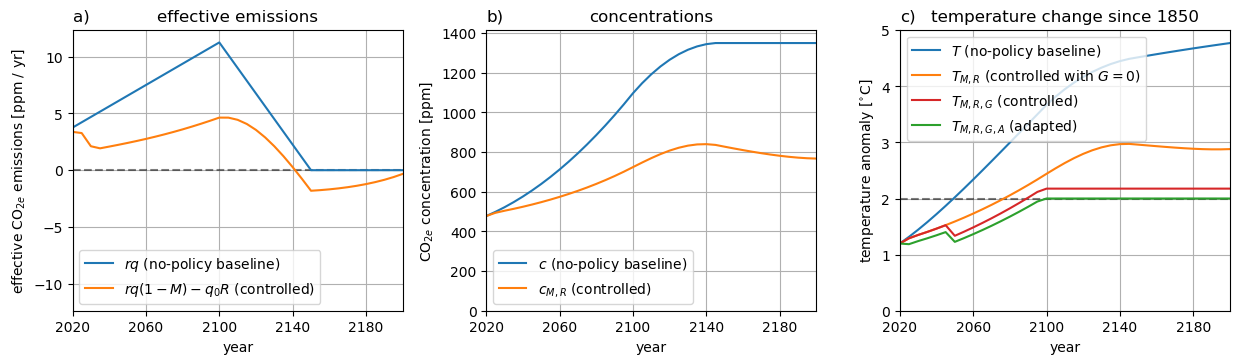

In [6]:
figure(figsize=(12.5,3.75))

subplot(1,3,1)
plot_emissions(model)
legend()
add_label("a)")
subplot(1,3,2)
plot_concentrations(model)
legend()
add_label("b)")
subplot(1,3,3)
plot_temperatures(model)
legend(loc="upper left")
add_label("c)")
tight_layout()
#savefig("../figures/default-temp_carbon_and_temperatures.pdf", dpi=150, bbox_inches="tight")

In [7]:
function f_asymp(α, μ)
    return α .^ 2. ./ (1. .- exp.(-(1 .- α)/(1. - μ)))
end
α = 0.:0.002:1.0

0.0:0.002:1.0

In [8]:
μ = 0.4
tmp_model = ClimateModel();
@time m = optimize_controls!(
    tmp_model,
    mitigation_penetration = μ,
);


Solve_Succeeded
  2.953929 seconds (3.89 M allocations: 194.074 MiB, 2.90% gc time)


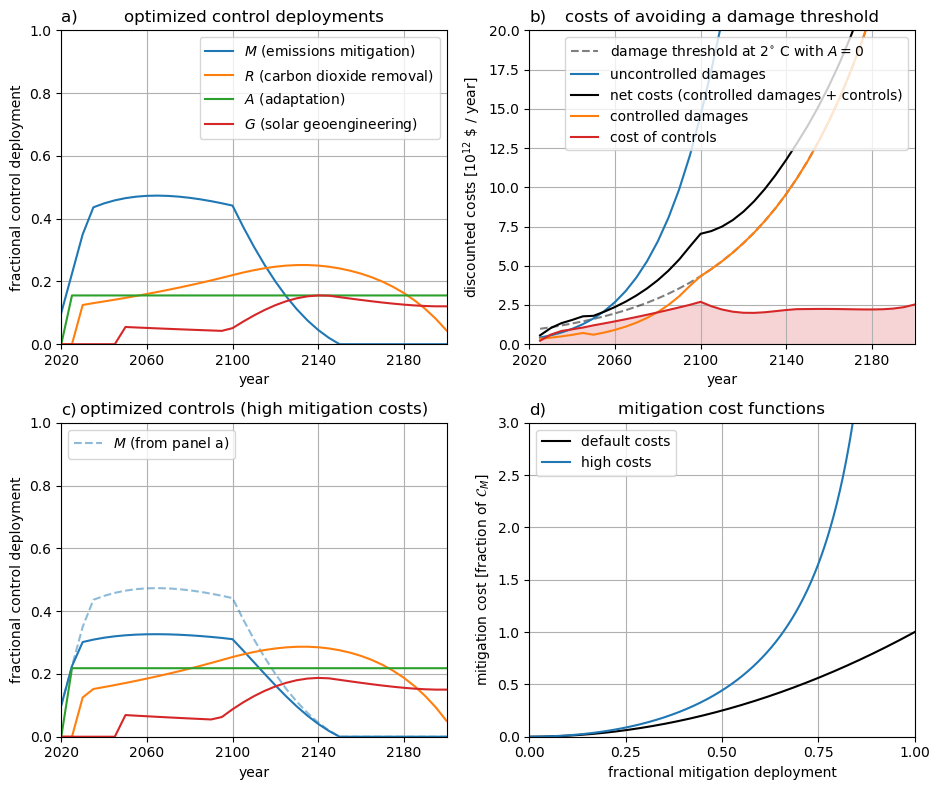

Net Present Control Costs: 135.85035538025375

In [9]:
figure(figsize=(9.5,8))

subplot(2,2,1)
plot_controls(model)
legend(loc="upper right")
title("a)", loc="left")

subplot(2,2,2)
plot_damages(model)
legend(loc="upper right")
title("b)", loc="left")
ylim([0, 20])

subplot(2,2,3)
plot(model.domain, model.controls.mitigate, "C0--", alpha=0.5, label=L"$M$ (from panel a)")
legend(loc="upper left")
plot_controls(tmp_model)
title("c)", loc="left")
title("optimized controls (high mitigation costs)")

subplot(2,2,4)
plot(α, α.^2, "k-", label="default costs")
plot(α, f_asymp(α, μ), label="high costs")
xlim([0,1])
ylim([0,3])
xticks([0., 0.25, 0.5, 0.75, 1.])
legend(loc="upper left")
ylabel(L"mitigation cost [fraction of $\mathcal{C}_{M}$]")
xlabel("fractional mitigation deployment")
title("mitigation cost functions")
title("d)", loc="left")
grid(true)

tight_layout()
#savefig("../figures/default-temp_controls_and_damages.pdf", dpi=150, bbox_inches="tight")

print("Net Present Control Costs: ", discounted_total_control_cost(model))